In [68]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Download the CELEBA dataset
- This notebook download CELEBA-HQ, and creates an HDF5 file with images and attributes at a specified size (e.g. 128x128x3).
- This is not the exact varient of CELEBA that I used for the trained model. But it should be similar enough to not make a difference. 
- Most of the code is based upon or modified from [https://github.com/tkarras/progressive_growing_of_gans](https://github.com/tkarras/progressive_growing_of_gans/blob/master/dataset_tool.py) that is part of the ProGAN github repo by Terro Karras at NVIDIA. 
    - This takes a long time. You can instead just grab the face images and skip all of the post-processing, or just grab a subset of the dataset. 
- **THIS NOTEBOOKS NEEDS TO RUN IN A PYTHON2 KERNEL**. Otherwise the MD5 of the image does not match up. 

In [26]:
import os
import sys
import io
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.ndimage
import PIL.Image
import h5py # conda install h5py
from tqdm import tqdm_notebook as tqdm
from PIL import Image
from sklearn.externals.joblib import Parallel, delayed

In [3]:
import hashlib
import bz2
import zipfile
import base64
import cryptography.hazmat.primitives.hashes
import cryptography.hazmat.backends
import cryptography.hazmat.primitives.kdf.pbkdf2
import cryptography.fernet

In [4]:
import dataset as ds

### Downlaod the dataset 

#### Create directory

In [5]:
dirpath = 'data/celebA/Img/img_celeba.7z/'
if os.path.exists(dirpath):
    print(dirpath + ' exists - skip')
else:
    os.makedirs(dirpath)

data/celebA/Img/img_celeba.7z/ exists - skip


#### Download the Img folder

In [6]:
z7_files = [
    '0B7EVK8r0v71pQy1YUGtHeUM2dUE',
    '0B7EVK8r0v71peFphOHpxODd5SjQ',
    '0B7EVK8r0v71pMk5FeXRlOXcxVVU',
    '0B7EVK8r0v71peXc4WldxZGFUbk0',
    '0B7EVK8r0v71pMktaV1hjZUJhLWM',
    '0B7EVK8r0v71pbWFfbGRDOVZxOUU',
    '0B7EVK8r0v71pQlZrOENSOUhkQ3c',
    '0B7EVK8r0v71pLVltX2F6dzVwT0E',
    '0B7EVK8r0v71pVlg5SmtLa1ZiU0k',
    '0B7EVK8r0v71pa09rcFF4THRmSFU',
    '0B7EVK8r0v71pNU9BZVBEMF9KN28',
    '0B7EVK8r0v71pTVd3R2NpQ0FHaGM',
    '0B7EVK8r0v71paXBad2lfSzlzSlk',
    '0B7EVK8r0v71pcTFwT1VFZzkzZk0'
]

In [7]:
for dii, drive_id in enumerate(tqdm(z7_files)):
    attrs_filename = 'img_celeba.7z.'+str(dii+1).zfill(3)
    save_path = os.path.join(dirpath, attrs_filename)
    if os.path.exists(save_path):
        print('[*] {} already exists'.format(save_path))
    else:
        ds.download_file_from_google_drive(drive_id, save_path)

HBox(children=(IntProgress(value=0, max=14), HTML(value=u'')))

[*] data/celebA/Img/img_celeba.7z/img_celeba.7z.001 already exists
[*] data/celebA/Img/img_celeba.7z/img_celeba.7z.002 already exists
[*] data/celebA/Img/img_celeba.7z/img_celeba.7z.003 already exists
[*] data/celebA/Img/img_celeba.7z/img_celeba.7z.004 already exists
[*] data/celebA/Img/img_celeba.7z/img_celeba.7z.005 already exists
[*] data/celebA/Img/img_celeba.7z/img_celeba.7z.006 already exists
[*] data/celebA/Img/img_celeba.7z/img_celeba.7z.007 already exists
[*] data/celebA/Img/img_celeba.7z/img_celeba.7z.008 already exists
[*] data/celebA/Img/img_celeba.7z/img_celeba.7z.009 already exists
[*] data/celebA/Img/img_celeba.7z/img_celeba.7z.010 already exists
[*] data/celebA/Img/img_celeba.7z/img_celeba.7z.011 already exists
[*] data/celebA/Img/img_celeba.7z/img_celeba.7z.012 already exists
[*] data/celebA/Img/img_celeba.7z/img_celeba.7z.013 already exists
[*] data/celebA/Img/img_celeba.7z/img_celeba.7z.014 already exists



#### Unzip the image files

In [8]:
outpath = '/'.join(dirpath.split('/')[:-2])+'/'
outpath

'data/celebA/Img/'

In [ ]:
for file_7z in np.sort(glob.glob(dirpath+'img_celeba.7z*')):
    !7z x $file_7z  -o$outpath

### Get attribute information

In [49]:
dirpath = "data/celebA/"
attrs_filename, drive_id = "list_attr_celeba.txt", "0B7EVK8r0v71pblRyaVFSWGxPY0U"
save_path = os.path.join(dirpath, attrs_filename)

In [162]:
with open(os.path.join(dirpath, 'list_attr_celeba.txt'), 'rt') as file:
        attrs = [line[:-1].split() for line in file.readlines()]
        attrs_head = attrs[1]
        attrs_body = attrs[2:]
attrs_body = np.array(attrs_body)[:,1:]
attrs_body = np.array(attrs_body).astype('int')

### Download the deltas files

In [9]:
dirpath = 'data/celebA/Img/deltas/'
if os.path.exists(dirpath):
    print(dirpath + ' exists - skip')
else:
    os.makedirs(dirpath)

data/celebA/Img/deltas/ exists - skip


In [10]:
delta_files = [['README.txt', '0B4qLcYyJmiz0U2hZTEJfaEZSMFE'],
                ['LICENSE.txt', '1y5k_G-3t-cjW01QMxXNfhcp95FCpts79'],
                ['img_list.txt', '0B4qLcYyJmiz0U25vdEVIU3NvNFk'],
                ['deltas00029.zip', '0B4qLcYyJmiz0U1pnMEI4WXN1S3M'],
                ['deltas00028.zip', '0B4qLcYyJmiz0U1BhWlFGRXc1aHc'],
                ['deltas00027.zip', '0B4qLcYyJmiz0U1BRYl9tSWFWVGM'],
                ['deltas00026.zip', '0B4qLcYyJmiz0U0tBanQ4cHNBUWc'],
                ['deltas00025.zip', '0B4qLcYyJmiz0U0lYX1J1Tk5vMjQ'],
                ['deltas00024.zip', '0B4qLcYyJmiz0U0YwQmluMmJuX2M'],
                ['deltas00023.zip', '0B4qLcYyJmiz0U05ZNG14X3ZjYW8'],
                ['deltas00022.zip', '0B4qLcYyJmiz0TzZySG9IWlZaeGc'],
                ['deltas00021.zip', '0B4qLcYyJmiz0TzBBNE8xbFhaSlU'],
                ['deltas00020.zip', '0B4qLcYyJmiz0TnJQSS1vZS1JYUE'],
                ['deltas00019.zip', '0B4qLcYyJmiz0TnBtdW83OXRfdG8'],
                ['deltas00018.zip', '0B4qLcYyJmiz0TmhIUGlVeE5pWjg'],
                ['deltas00017.zip', '0B4qLcYyJmiz0TmZqZXN3UWFkUm8'],
                ['deltas00016.zip', '0B4qLcYyJmiz0TmVkVGJmWEtVbFk'],
                ['deltas00015.zip', '0B4qLcYyJmiz0TmRZTmZyenViSjg'],
                ['deltas00014.zip', '0B4qLcYyJmiz0Tm5MSUp3ZTZ0aTg'],
                ['deltas00013.zip', '0B4qLcYyJmiz0TlpJU1pleF9zbnM'],
                ['deltas00012.zip', '0B4qLcYyJmiz0Tlhvdl9zYlV4UUE'],
                ['deltas00011.zip', '0B4qLcYyJmiz0TlNyLUtOTzk3QjQ'],
                ['deltas00010.zip', '0B4qLcYyJmiz0TlBCNFU3QkctNkk'],
                ['deltas00009.zip', '0B4qLcYyJmiz0Tl9wNEU2WWRqcE0'],
                ['deltas00008.zip', '0B4qLcYyJmiz0Tksyd21vRmVqamc'],
                ['deltas00007.zip', '0B4qLcYyJmiz0TjdaV2ZsQU94MnM'],
                ['deltas00006.zip', '0B4qLcYyJmiz0TjVkYkF4dTJRNUk'],
                ['deltas00005.zip', '0B4qLcYyJmiz0TjRzeWlhLVJIYk0'],
                ['deltas00004.zip', '0B4qLcYyJmiz0TjRxVkZ1NGxHTXc'],
                ['deltas00003.zip', '0B4qLcYyJmiz0TjRWUXVvM3hZZE0'],
                ['deltas00002.zip', '0B4qLcYyJmiz0TjNRV2dUamd0bEU'],
                ['deltas00001.zip', '0B4qLcYyJmiz0TjAwOTRBVmRKRzQ'],
                ['deltas00000.zip', '0B4qLcYyJmiz0TXdaTExNcW03ejA']
              ]

In [11]:
for dii, (fname, drive_id) in enumerate(tqdm(delta_files)):
    save_path = os.path.join(dirpath, fname)
    if os.path.exists(save_path):
        print('[*] {} already exists'.format(save_path))
    else:
        ds.download_file_from_google_drive(drive_id, save_path)

HBox(children=(IntProgress(value=0, max=33), HTML(value=u'')))

[*] data/celebA/Img/deltas/README.txt already exists
[*] data/celebA/Img/deltas/LICENSE.txt already exists
[*] data/celebA/Img/deltas/img_list.txt already exists
[*] data/celebA/Img/deltas/deltas00029.zip already exists
[*] data/celebA/Img/deltas/deltas00028.zip already exists
[*] data/celebA/Img/deltas/deltas00027.zip already exists
[*] data/celebA/Img/deltas/deltas00026.zip already exists
[*] data/celebA/Img/deltas/deltas00025.zip already exists
[*] data/celebA/Img/deltas/deltas00024.zip already exists
[*] data/celebA/Img/deltas/deltas00023.zip already exists
[*] data/celebA/Img/deltas/deltas00022.zip already exists
[*] data/celebA/Img/deltas/deltas00021.zip already exists
[*] data/celebA/Img/deltas/deltas00020.zip already exists
[*] data/celebA/Img/deltas/deltas00019.zip already exists
[*] data/celebA/Img/deltas/deltas00018.zip already exists
[*] data/celebA/Img/deltas/deltas00017.zip already exists
[*] data/celebA/Img/deltas/deltas00016.zip already exists
[*] data/celebA/Img/deltas

### Test processing a few images

In [12]:
celeba_dir = 'data/celebA/Img/img_celeba/'
delta_dir = 'data/celebA/Img/deltas/'

In [13]:
fields, landmarks = ds.get_fields_landmarks(celeba_dir, delta_dir)

Loading CelebA data from /mnt/cube/Datasets/celeba/celeba/drive/Img
Loading CelebA-HQ deltas from /mnt/cube/Datasets/celeba/deltas


HBox(children=(IntProgress(value=0, max=5), HTML(value=u'')))

In [14]:
dim = 128 # what size to make the images

HBox(children=(IntProgress(value=0, max=1), HTML(value=u'')))

3


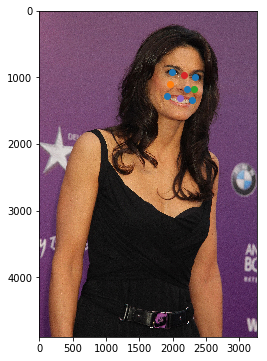

('Top-bottom', 0.6402123, 'left right', 2.4578009)
(4896, 3264, 3)
[[ 1994.   925.]
 [ 2337.   993.]
 [ 2210.  1179.]
 [ 1916.  1287.]
 [ 2298.  1346.]]
shrink


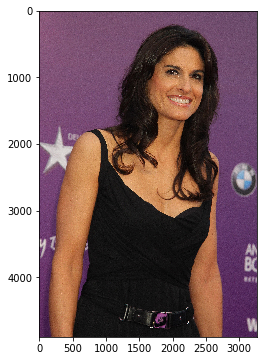

crop


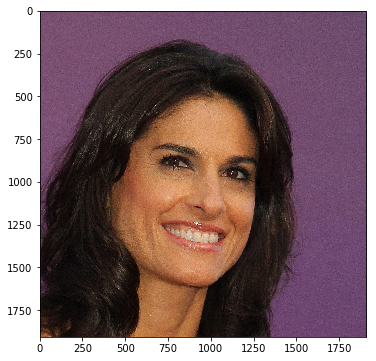

superres


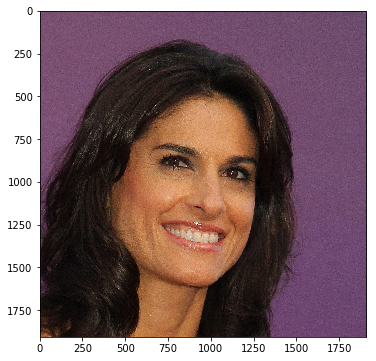

pad
(1906, 1906, 3)


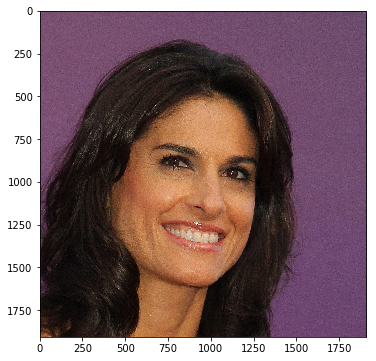

transform


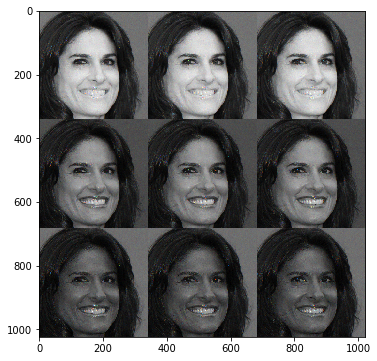

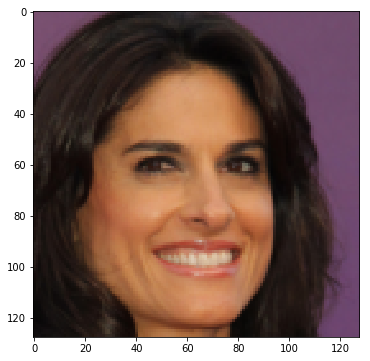

In [357]:
for idx in tqdm(fields['idx'][3:4]):
    print(idx)
    _= ds.process_img_celeb_hq(celeba_dir=celeba_dir,delta_dir=delta_dir,idx=idx,
                               lm=landmarks[fields['orig_idx'][idx]],
                               orig_idx = fields['orig_idx'][idx], 
                               orig_file = fields['orig_file'][idx], 
                               proc_md5 = fields['proc_md5'][idx],
                               final_md5 = fields['final_md5'][idx],
                               final_size = dim, verbose=True)

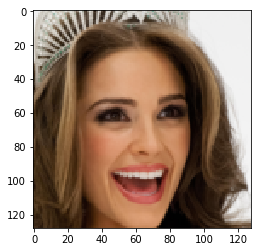

In [30]:
plt.imshow(img.reshape(dim,dim,3))

HBox(children=(IntProgress(value=0, max=2), HTML(value=u'')))

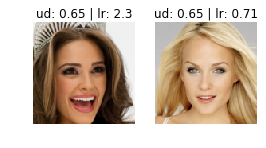

In [69]:
imsize = 2; nex = 2
fig, ax = plt.subplots(nrows=1,ncols=nex, figsize=(imsize*nex,imsize))
for i,idx in enumerate(tqdm(fields['idx'][:nex])):
    img,  up_down, left_right, idx = ds.process_img_celeb_hq(celeba_dir=celeba_dir,delta_dir=delta_dir,idx=idx,
                               lm=landmarks[fields['orig_idx'][idx]],
                               orig_idx = fields['orig_idx'][idx], 
                               orig_file = fields['orig_file'][idx], 
                               proc_md5 = fields['proc_md5'][idx],
                               final_md5 = fields['final_md5'][idx],
                               final_size = dim, verbose=False)
    if img is None:
        ax[i].axis('off'); continue
    ax[i].imshow(np.reshape(img/255., (dim,dim,3)), interpolation="None"); ax[i].axis('off')
    ax[i].set_title('ud: '+str(round(up_down,2)) +' | lr: '+ str(round(left_right,2)))
plt.show()

### Create dataset

In [346]:
n_jobs = 15 # adjust this based on how many threads you can use
chunk_size =  n_jobs*20 # adjust this based on how much memory you have available

In [347]:
size = 128
path = 'data/CELEBA-'+str(size)+'-Annot-hq.h5'

In [348]:
# create reservoir list of each data item
# grab a chunk
# remove the bad parts
# add that data to the reservoir list

In [349]:
np.shape(attrs_body)

(202599, 40)

In [355]:
dset_size = len(fields['idx'])
dset_size

30000

In [356]:
with Parallel(n_jobs=n_jobs, verbose=0) as parallel:
    with h5py.File(path, 'w') as f:
        # prepare dataasets
        dset_label_input = f.create_dataset('attrs_head', data = np.string_(attrs_head))
        dset = f.create_dataset('images', (0,dim*dim*3), maxshape=(None,dim*dim*3),
                                dtype='uint8', chunks=(chunk_size,dim*dim*3))
        dset_attrs = f.create_dataset('attrs', (0,40), maxshape=(None,40),
                                dtype='bool', chunks=(chunk_size,40))
        dset_rot = f.create_dataset('rot_lr_ud', (0,2), maxshape=(None,2),
                                dtype='float32', chunks=(chunk_size,2))
        
        # loop through chunks
        for chunk in tqdm(np.arange(dset_size // chunk_size)):
            imgs, up_down, left_right, idxs = np.array(parallel(delayed(ds.process_img_celeb_hq)( 
                celeba_dir=celeba_dir,delta_dir=delta_dir,idx=idx,
                lm=landmarks[fields['orig_idx'][idx]],
                orig_idx = fields['orig_idx'][idx], 
                orig_file = fields['orig_file'][idx], 
                proc_md5 = fields['proc_md5'][idx],
                final_md5 = fields['final_md5'][idx],
                final_size = dim, verbose=False
                        ) for i, (idx) in enumerate(tqdm(fields['idx'][chunk_size*chunk:chunk_size*(chunk+1)])))).T

            # grab only the good parts of the data
            mask = up_down != None
            good_images = np.stack(imgs[mask]).astype('uint8')
            good_attrs = attrs_body[idxs[mask].astype('int')] > 0
    
            # add to dataset
            dset.resize(dset.shape[0]+len(good_images), axis=0)
            dset[-len(good_images):] = good_images
            dset_attrs.resize(dset_attrs.shape[0]+len(good_attrs), axis=0)
            dset_attrs[-len(good_attrs):] = good_attrs
            dset_rot.resize(dset_rot.shape[0]+len(good_attrs), axis=0)
            dset_rot[-len(good_attrs):] = np.hstack([np.vstack(left_right[mask]), np.vstack(up_down[mask])])
            
            # sdd flipped data to dataset
            dset.resize(dset.shape[0]+len(good_images), axis=0)
            dset[-len(good_images):] = np.flip(good_images.reshape((len(good_images), size, size, 3)), axis = 2).reshape(np.shape(good_images))
            dset_attrs.resize(dset_attrs.shape[0]+len(good_attrs), axis=0)
            dset_attrs[-len(good_attrs):] = good_attrs
            dset_rot.resize(dset_rot.shape[0]+len(good_attrs), axis=0)
            dset_rot[-len(good_attrs):] = np.hstack([np.vstack(1./left_right[mask]), np.vstack(up_down[mask])])
            


HBox(children=(IntProgress(value=0), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

### Test read a face

In [305]:
with h5py.File(path, 'r') as hf:
    face = hf['images'][1]
    attr = hf['attrs'][1]
    rot = hf['rot_lr_ud'][1]
    print(len(hf['images']))

108


In [306]:
type(face[0]), type(attr[0]), type(rot[0])

(numpy.uint8, numpy.bool_, numpy.float32)

['Arched_Eyebrows' 'Attractive' 'Blond_Hair' 'Heavy_Makeup'
 'Mouth_Slightly_Open' 'No_Beard' 'Smiling' 'Wavy_Hair' 'Wearing_Lipstick'
 'Young']


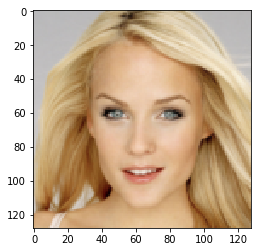

In [307]:
plt.imshow(face.reshape((dim,dim,3)))
print(np.array(attrs_head)[np.array(attr)])

In [308]:
with h5py.File(path, 'r') as hf:
    faces = hf['images'][:200].astype('uint8')

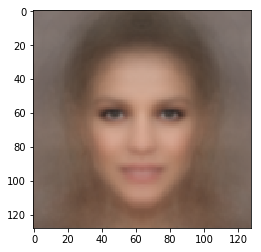

In [309]:
plt.imshow(np.reshape(np.mean(faces, axis = 0)/255, (dim,dim,3)))

In [310]:
nx = 5
ny = 15
canvas = np.zeros((dim*nx,dim*ny,3), dtype='uint8')
for x in np.arange(nx):
    for y in np.arange(ny):
        canvas[x*dim:(x+1)*dim,y*dim:(y+1)*dim,:] = faces[x*ny+y].reshape((dim,dim,3))

(-0.5, 1919.5, 639.5, -0.5)

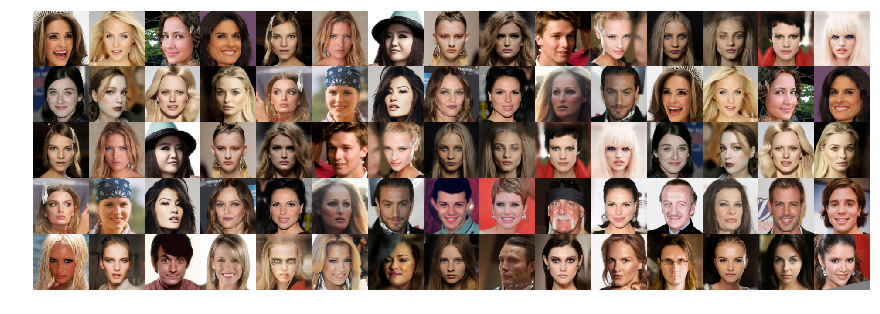

In [311]:
z =3
fig, ax = plt.subplots(figsize=(nx*z, ny*z))
ax.imshow(canvas)
ax.axis('off')

### Test read attributes

In [312]:
ex = 1
with h5py.File(path, 'r') as hf:
    print(len(hf['images']))
    face = hf['images'][ex].astype('uint8')
    attrs = hf['attrs'][ex]
    
    print(list(hf.keys()))

108
[u'attrs', u'attrs_head', u'images', u'rot_lr_ud']


In [313]:
print(' | '.join([str(i)+' '+j for i,j in enumerate(attrs_head)]))

0 5_o_Clock_Shadow | 1 Arched_Eyebrows | 2 Attractive | 3 Bags_Under_Eyes | 4 Bald | 5 Bangs | 6 Big_Lips | 7 Big_Nose | 8 Black_Hair | 9 Blond_Hair | 10 Blurry | 11 Brown_Hair | 12 Bushy_Eyebrows | 13 Chubby | 14 Double_Chin | 15 Eyeglasses | 16 Goatee | 17 Gray_Hair | 18 Heavy_Makeup | 19 High_Cheekbones | 20 Male | 21 Mouth_Slightly_Open | 22 Mustache | 23 Narrow_Eyes | 24 No_Beard | 25 Oval_Face | 26 Pale_Skin | 27 Pointy_Nose | 28 Receding_Hairline | 29 Rosy_Cheeks | 30 Sideburns | 31 Smiling | 32 Straight_Hair | 33 Wavy_Hair | 34 Wearing_Earrings | 35 Wearing_Hat | 36 Wearing_Lipstick | 37 Wearing_Necklace | 38 Wearing_Necktie | 39 Young


In [314]:
np.shape(face)

(49152,)

['Arched_Eyebrows' 'Attractive' 'Blond_Hair' 'Heavy_Makeup'
 'Mouth_Slightly_Open' 'No_Beard' 'Smiling' 'Wavy_Hair' 'Wearing_Lipstick'
 'Young']


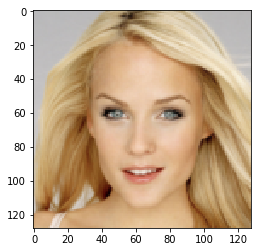

In [315]:
plt.imshow(face.reshape((dim,dim,3)))
print(np.array(attrs_head)[attrs[:40]==1])

In [321]:
with h5py.File(path, 'r') as hf:
    face = hf['images'][-1000:].astype('uint8')
    attrs = hf['attrs'][-1000:]
    rot = hf['rot_lr_ud'][-1000:]

    print(list(hf.keys()))

[u'attrs', u'attrs_head', u'images', u'rot_lr_ud']


In [322]:
attr_num = 9
attrs_head[attr_num]

'Blond_Hair'

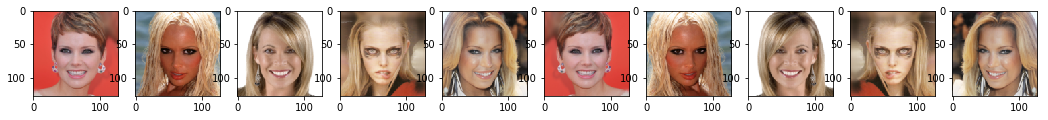

In [325]:
nex = 10
zoom = 3
fig, ax = plt.subplots(nrows=1,ncols=nex, figsize=(6*zoom,nex*zoom))
for i,face_i in enumerate(face[attrs[:,attr_num]==1][-nex:]):
    ax[i].imshow(face_i.reshape((dim,dim,3)))

### Test face direction attribute

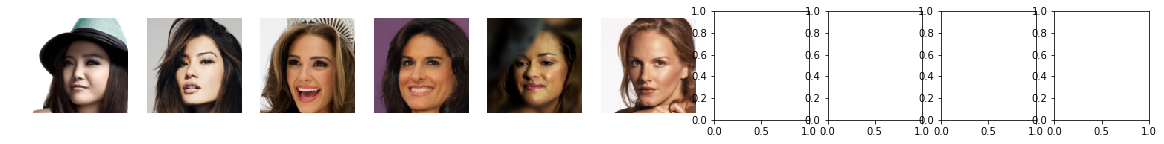

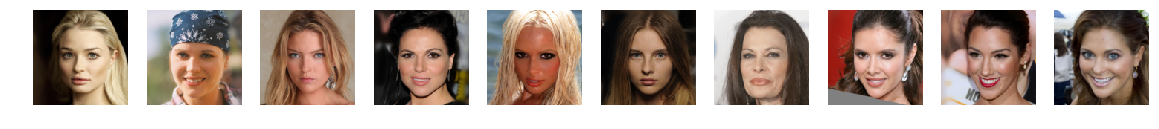

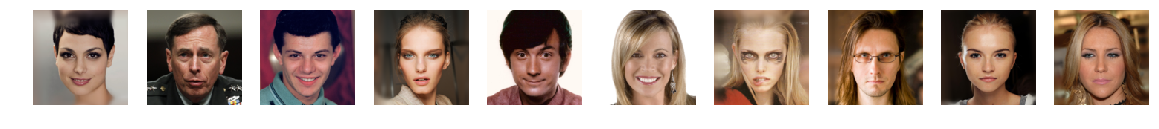

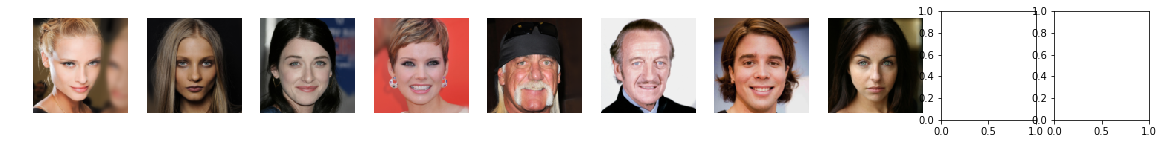

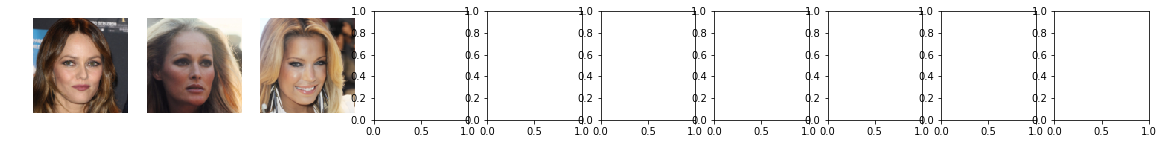

In [337]:
# left right
zoom = 2
nex = 10
for dirup,dirdown in zip(np.linspace(-1,1,7)[1:], np.linspace(-1,1,6)[:-1]):
    fig, ax = plt.subplots(nrows=1,ncols=nex, figsize=(zoom*nex,zoom))
    f = face[(np.log(rot[:,0]) < dirup) & (np.log(rot[:,0]) > dirdown)][-nex:]
    for i in range(len(f)): ax[i].imshow(f[i].reshape((dim,dim,3))); ax[i].axis('off')
    plt.show()

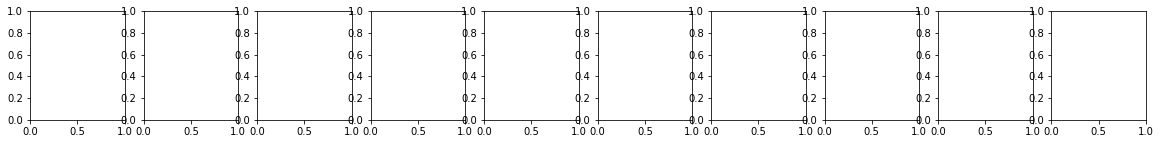

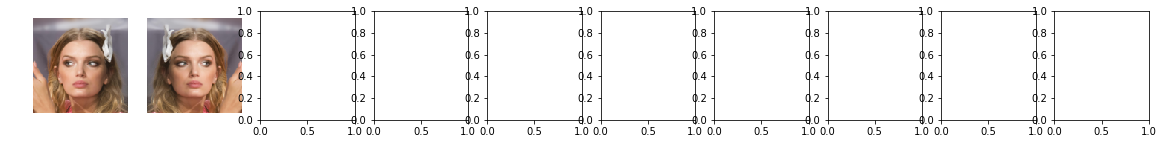

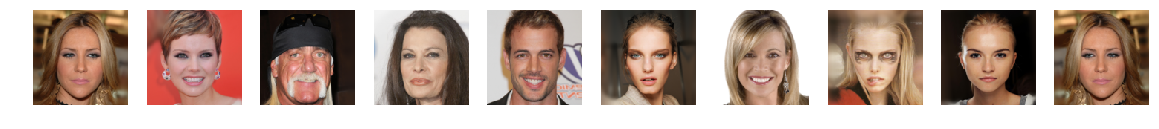

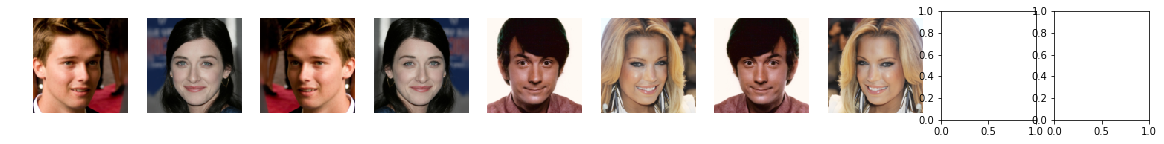

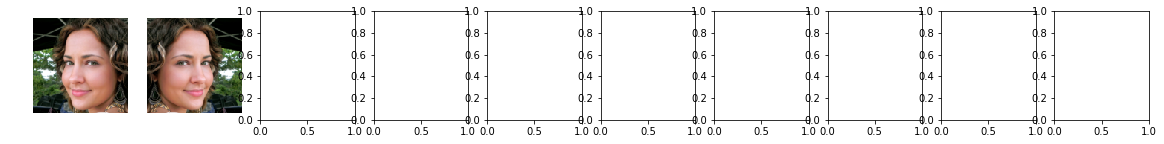

In [340]:
# up down 
zoom = 2
nex = 10
for dirup,dirdown in zip(np.linspace(.25,1,7)[1:], np.linspace(.25,1,6)[:-1]):
    fig, ax = plt.subplots(nrows=1,ncols=nex, figsize=(zoom*nex,zoom))
    f = face[((rot[:,1]) < dirup) & ((rot[:,1]) > dirdown)][-nex:]
    for i in range(len(f)): ax[i].imshow(f[i].reshape((dim,dim,3))); ax[i].axis('off')
    plt.show()